In [37]:
# Import 3rd party libraries
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt

# Import local libraries
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.base import clone
from sklearn.metrics import mean_squared_error

# Configure Notebook
%matplotlib inline
plt.style.use('fivethirtyeight')
sns.set_context("notebook")
import warnings
warnings.filterwarnings('ignore')

Read the data file.

In [2]:
data = pd.read_pickle('df_LA_parcels_LAcity_cleaned_REV2_MB.pkl', compression = "gzip")
data = data[data['TotalValue'] <= 2000000]
data = data[data['Neighborhood'].str.contains('Griffith Park') == False] # This is an outlier

In [3]:
data.shape

(417991, 20)

In [4]:
crime_data = pd.read_csv('neighbourhoods_crime_count_2010_to_2019.csv')
crime_data = crime_data[['name', 'crime_count']].rename(columns = {'name': 'Neighborhood'})
data = data.merge(crime_data, on = 'Neighborhood')
data

,AIN,SQFTmain,Bedrooms,Bathrooms,LandValue,LandBaseYear,TotalValue,YearBuilt,EffectiveYearBuilt,PropertyUseCode,...,Cluster,ZIPcode5,ZIPcode4,BusBenchClosestDist,SubwayStopClosestDist,Neighborhood,ShapeSTAre,ShapeSTLen,geometry,crime_count
0,2012031006,1650.0,4,2,236718.0,2011,368094.0,1963,1963,0100,...,2143,91304,3821,627.902037,81059.153781,Canoga Park,8115.922852,377.443437,"POLYGON ((-118.60779 34.21852, -118.60814 34.2...",4405
1,2012002007,1327.0,3,2,135211.0,1989,338036.0,1957,1957,0100,...,2143,91304,3838,199.820206,81531.724666,Canoga Park,8399.689453,379.990318,"POLYGON ((-118.60960 34.21914, -118.60983 34.2...",4405
2,2023013004,714.0,2,1,246192.0,2003,307598.0,1953,1953,0100,...,2143,91303,1112,1006.955311,77072.886615,Canoga Park,6749.179688,369.982730,"POLYGON ((-118.60956 34.20548, -118.60956 34.2...",4405
3,2023025020,1657.0,3,2,212535.0,1989,279800.0,1956,1966,0100,...,2143,91303,1011,1085.125000,77005.109741,Canoga Park,7629.740234,358.002982,"POLYGON ((-118.61205 34.20399, -118.61204 34.2...",4405
4,2023004004,1876.0,6,2,285871.0,1990,407892.0,1942,1947,0101,...,2143,91303,1110,634.633252,76729.509756,Canoga Park,13498.103516,469.973496,"POLYGON ((-118.60738 34.20548, -118.60721 34.2...",4405
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
417986,7559018006,2187.0,4,3,654147.0,2018,830954.0,1955,1963,0100,...,14190,90732,3120,1388.764601,37850.477861,San Pedro,6029.481445,322.234960,"POLYGON ((-118.31383 33.74287, -118.31383 33.7...",8957
417987,7559008011,1305.0,3,2,609000.0,2007,762000.0,1955,1955,0100,...,14190,90732,2713,1882.772648,38133.074377,San Pedro,8677.246094,402.365689,"POLYGON ((-118.31531 33.74506, -118.31552 33.7...",8957
417988,7562022007,1910.0,3,2,51162.0,1975,124294.0,1961,1961,0100,...,14190,90732,4119,648.733626,42062.411545,San Pedro,6747.458984,334.916599,"POLYGON ((-118.32218 33.72681, -118.32230 33.7...",8957
417989,7563021007,4541.0,4,4,492258.0,2013,1251407.0,2007,2007,0100,...,14190,90732,4720,1809.655573,42164.699128,San Pedro,6000.456055,320.017959,"POLYGON ((-118.31985 33.72131, -118.31996 33.7...",8957


In [5]:
neighborhood_cluster_data = pd.read_pickle('neighborhoods_cluster.pkl')
data = data.merge(neighborhood_cluster_data[['Neighborhood', 'cluster']], on = 'Neighborhood')
data

,AIN,SQFTmain,Bedrooms,Bathrooms,LandValue,LandBaseYear,TotalValue,YearBuilt,EffectiveYearBuilt,PropertyUseCode,...,ZIPcode5,ZIPcode4,BusBenchClosestDist,SubwayStopClosestDist,Neighborhood,ShapeSTAre,ShapeSTLen,geometry,crime_count,cluster
0,2012031006,1650.0,4,2,236718.0,2011,368094.0,1963,1963,0100,...,91304,3821,627.902037,81059.153781,Canoga Park,8115.922852,377.443437,"POLYGON ((-118.60779 34.21852, -118.60814 34.2...",4405,4
1,2012002007,1327.0,3,2,135211.0,1989,338036.0,1957,1957,0100,...,91304,3838,199.820206,81531.724666,Canoga Park,8399.689453,379.990318,"POLYGON ((-118.60960 34.21914, -118.60983 34.2...",4405,4
2,2023013004,714.0,2,1,246192.0,2003,307598.0,1953,1953,0100,...,91303,1112,1006.955311,77072.886615,Canoga Park,6749.179688,369.982730,"POLYGON ((-118.60956 34.20548, -118.60956 34.2...",4405,4
3,2023025020,1657.0,3,2,212535.0,1989,279800.0,1956,1966,0100,...,91303,1011,1085.125000,77005.109741,Canoga Park,7629.740234,358.002982,"POLYGON ((-118.61205 34.20399, -118.61204 34.2...",4405,4
4,2023004004,1876.0,6,2,285871.0,1990,407892.0,1942,1947,0101,...,91303,1110,634.633252,76729.509756,Canoga Park,13498.103516,469.973496,"POLYGON ((-118.60738 34.20548, -118.60721 34.2...",4405,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
417986,7559018006,2187.0,4,3,654147.0,2018,830954.0,1955,1963,0100,...,90732,3120,1388.764601,37850.477861,San Pedro,6029.481445,322.234960,"POLYGON ((-118.31383 33.74287, -118.31383 33.7...",8957,4
417987,7559008011,1305.0,3,2,609000.0,2007,762000.0,1955,1955,0100,...,90732,2713,1882.772648,38133.074377,San Pedro,8677.246094,402.365689,"POLYGON ((-118.31531 33.74506, -118.31552 33.7...",8957,4
417988,7562022007,1910.0,3,2,51162.0,1975,124294.0,1961,1961,0100,...,90732,4119,648.733626,42062.411545,San Pedro,6747.458984,334.916599,"POLYGON ((-118.32218 33.72681, -118.32230 33.7...",8957,4
417989,7563021007,4541.0,4,4,492258.0,2013,1251407.0,2007,2007,0100,...,90732,4720,1809.655573,42164.699128,San Pedro,6000.456055,320.017959,"POLYGON ((-118.31985 33.72131, -118.31996 33.7...",8957,4


Check out the correlation between each of the current features of the data set.

In [6]:
correlation = data.corr()

In [7]:
correlation

,AIN,SQFTmain,Bedrooms,Bathrooms,LandValue,LandBaseYear,TotalValue,YearBuilt,EffectiveYearBuilt,TaxRateArea,Cluster,ZIPcode5,BusBenchClosestDist,SubwayStopClosestDist,ShapeSTAre,ShapeSTLen,crime_count
AIN,1.000000,-0.179812,-0.225205,-0.233227,0.002198,-0.054774,-0.066662,-0.418312,-0.365073,0.008864,0.830914,-0.825312,-0.032332,-0.614568,-0.203228,-0.226468,-0.223031
SQFTmain,-0.179812,1.000000,0.647474,0.819407,0.307814,-0.014653,0.500990,0.394750,0.484244,-0.047995,-0.172559,0.132974,0.259634,0.188972,0.363467,0.419733,-0.088974
Bedrooms,-0.225205,0.647474,1.000000,0.651821,0.126503,0.009686,0.258229,0.347847,0.434352,-0.021023,-0.191702,0.224629,0.121317,0.292311,0.200032,0.235687,0.039100
Bathrooms,-0.233227,0.819407,0.651821,1.000000,0.293537,0.036667,0.469741,0.480377,0.599910,-0.048935,-0.221764,0.199417,0.240393,0.238472,0.287968,0.329468,-0.065150
LandValue,0.002198,0.307814,0.126503,0.293537,1.000000,0.618352,0.949364,0.087236,0.180084,-0.046918,-0.011803,-0.090732,0.147399,-0.080698,0.121652,0.138493,-0.215423
LandBaseYear,-0.054774,-0.014653,0.009686,0.036667,0.618352,1.000000,0.574064,0.063101,0.120769,0.016739,-0.053266,0.063693,-0.015329,0.047280,-0.027339,-0.034948,0.048150
TotalValue,-0.066662,0.500990,0.258229,0.469741,0.949364,0.574064,1.000000,0.215509,0.326938,-0.052627,-0.075075,-0.020359,0.199868,-0.010853,0.190470,0.216579,-0.199606
YearBuilt,-0.418312,0.394750,0.347847,0.480377,0.087236,0.063101,0.215509,1.000000,0.854818,-0.024475,-0.381231,0.473667,0.232888,0.506799,0.188496,0.204839,0.090084
EffectiveYearBuilt,-0.365073,0.484244,0.434352,0.599910,0.180084,0.120769,0.326938,0.854818,1.000000,-0.028758,-0.328556,0.401991,0.209069,0.409613,0.178307,0.198818,0.046346
TaxRateArea,0.008864,-0.047995,-0.021023,-0.048935,-0.046918,0.016739,-0.052627,-0.024475,-0.028758,1.000000,0.041323,0.021483,-0.039102,0.047516,-0.026556,-0.027413,0.106985


Look at the info of each column in the data set.

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 417991 entries, 0 to 417990
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype   
---  ------                 --------------   -----   
 0   AIN                    417991 non-null  int64   
 1   SQFTmain               417991 non-null  float64 
 2   Bedrooms               417991 non-null  int64   
 3   Bathrooms              417991 non-null  int64   
 4   LandValue              417991 non-null  float64 
 5   LandBaseYear           417991 non-null  int64   
 6   TotalValue             417991 non-null  float64 
 7   YearBuilt              417991 non-null  int64   
 8   EffectiveYearBuilt     417991 non-null  int64   
 9   PropertyUseCode        417991 non-null  object  
 10  TaxRateArea            417991 non-null  int64   
 11  Cluster                417991 non-null  int64   
 12  ZIPcode5               417991 non-null  int64   
 13  ZIPcode4               416208 non-null  object  
 14  BusBenchClosestDist 

In [9]:
data.isnull().sum()

AIN                         0
SQFTmain                    0
Bedrooms                    0
Bathrooms                   0
LandValue                   0
LandBaseYear                0
TotalValue                  0
YearBuilt                   0
EffectiveYearBuilt          0
PropertyUseCode             0
TaxRateArea                 0
Cluster                     0
ZIPcode5                    0
ZIPcode4                 1783
BusBenchClosestDist         0
SubwayStopClosestDist       0
Neighborhood                0
ShapeSTAre                  0
ShapeSTLen                  0
geometry                    0
crime_count                 0
cluster                     0
dtype: int64

Label the data into groups based on TotalValue, split into 4 groups. This is for stratifying the dataset when splitting into train, test, val sets so that the data split is balanced.

In [10]:
# Group the data into Quartiles based on TotalValue for stratifying purposes
data['Quartile_Number'] = 0

data.loc[
    (data['TotalValue'] >= 0) & 
    (data['TotalValue'] < data['TotalValue'].quantile(0.25)), 
    'Quartile_Number'] = 1

data.loc[
    (data['TotalValue'] >= data['TotalValue'].quantile(0.25)) & 
    (data['TotalValue'] < data['TotalValue'].quantile(0.5)), 
    'Quartile_Number'] = 2

data.loc[
    (data['TotalValue'] >= data['TotalValue'].quantile(0.5)) & 
    (data['TotalValue'] < data['TotalValue'].quantile(0.75)), 
    'Quartile_Number'] = 3

data.loc[
    (data['TotalValue'] >= data['TotalValue'].quantile(0.75)), 
    'Quartile_Number'] = 4

Split the data into training set, validation set, and test set.

In [11]:
train, evaluate = train_test_split(data, test_size = 0.3, random_state = 0, stratify = data['Quartile_Number'])
val, test = train_test_split(evaluate, test_size = 0.5, random_state = 0, stratify = evaluate['Quartile_Number'])

# Print results
print('Train {}%'.format(train.shape[0] / data.shape[0] * 100))
print('Val {}%'.format(val.shape[0] / data.shape[0] * 100))
print('Test {}%'.format(test.shape[0] / data.shape[0] * 100))

Train 69.9998325322794%
Val 15.000083733860297%
Test 15.000083733860297%


## Feature Engineering

Keep a list of thoughts of each feature and what to do with each feature <br>

Feature: <br>

AIN: No application. <br>

SQFTmain: Directly into Linear Regression Model. <br>

Bedrooms: Directly into Linear Regression Model. <br>

Bathrooms: Directly into Linear Regression Model. <br>

LandValue: Does not make sense to include in model, this would be part of the answer. Data leakage <br>

LandBaseYear: Defines how recently a piece of land was sold. Directly into model. <br>

TotalValue: This is the target. <br>

YearBuilt: Either this or the one below goes into the model. Effective year built also includes renovations and improvements but those could be subjective measures. <br>

EffectiveYearBuilt: Directly into Linear Regression Model. <br>

PropertyUseCode: Can one-hot-encode to measure changes in home value due to pool/no pool. <br>

TaxRateArea: Bad correlation with total value, so probably not useful in the ML model. <br>

Cluster: Bad correlation with total value, so probably not useful in the ML model. <br>

Zipcode5: No apparent correlation with TotalValue, might not be useful to predicting home prices. <br>

Zipcode4: Similar to zipcode5, but even worse because there are null values present. <br>

BusBenchClosestDist: Directly into Linear Regression Model. <br>

SubwayStopClosestDist: May not be the best indicator of home prices because subways can be quite loud to live near, so the convenience vs. noise may conflict with each other. Also must consider the quality of the subways in California, this would probably be a more useful feature in New York. <br>

Neighborhood: After graphing vs. TotalValue, it seems that all rich neighborhoods have cheap homes in them as well. This can be a good feature to detect strictly poor neighborhoods to add as a feature in the model, but might not be useful for rich neighborhoods due to high variance of home prices. <br>

ShapeSTAre: Directly into Linear Regression Model. <br>

ShapeSTLen: It seems redundant to include with ShapeSTAre. Try including it and see if the model improves. <br>

geometry: Maybe there could be a correlation to find what shapes of lots are more attractive. <br>

<br>
One hot encode the property use code to distinguish between homes with pools, without pools, etc.

In [12]:
def ohe_pusecode(data):
    """
    One-hot-encodes Property Use Code.
    New columns are of the form PropertyUseCode_CODE
    """
    # List categories
    categories = ['0100', # No Pool
                  '0101', # Pool
                  '0103', # Pool and misc.
                  '0104', # Therapy Pool
                  ]

    category_type = pd.CategoricalDtype(categories=categories)
    data['PropertyUseCode'] = data['PropertyUseCode'].astype(category_type)
    data = pd.get_dummies(data, 
                          prefix='PropertyUseCode',
                          columns=['PropertyUseCode'], 
                          drop_first=True) # Avoid redundant information
    
    return data

# Encode 'PropertyUseCode'
training_data = ohe_pusecode(train)

In [13]:
training_data

,AIN,SQFTmain,Bedrooms,Bathrooms,LandValue,LandBaseYear,TotalValue,YearBuilt,EffectiveYearBuilt,TaxRateArea,...,Neighborhood,ShapeSTAre,ShapeSTLen,geometry,crime_count,cluster,Quartile_Number,PropertyUseCode_0101,PropertyUseCode_0103,PropertyUseCode_0104
117020,2341013010,1322.0,3,2,529003.0,2013,654140.0,1947,1950,13,...,Valley Glen,7970.215820,385.672880,"POLYGON ((-118.40716 34.17658, -118.40716 34.1...",5110,4,3,1,0,0
102924,2265002172,2716.0,5,3,1231729.0,2020,1540798.0,1986,1989,13,...,Sherman Oaks,7952.088867,384.606197,"POLYGON ((-118.45317 34.15447, -118.45317 34.1...",6178,4,4,1,0,0
78262,2184010010,2332.0,3,3,758543.0,2009,948175.0,1954,1960,37,...,Tarzana,18000.024414,539.995882,"POLYGON ((-118.52912 34.15407, -118.52924 34.1...",5020,4,4,1,0,0
156735,2503012009,1358.0,3,2,204177.0,2003,333154.0,1956,1956,16,...,Sylmar,8758.860352,385.970876,"POLYGON ((-118.42947 34.32229, -118.42974 34.3...",8720,4,2,0,0,0
186136,2607008026,3070.0,4,3,652000.0,2006,987000.0,1962,1963,16,...,Granada Hills,17061.231445,529.074601,"POLYGON ((-118.51139 34.28168, -118.51139 34.2...",7056,4,4,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391660,6074014017,1109.0,2,1,284588.0,2005,392752.0,1950,1953,461,...,Broadway-Manchester,5320.931641,346.052412,"POLYGON ((-118.27696 33.93659, -118.27696 33.9...",6658,4,2,0,0,0
289723,4411017012,3412.0,4,4,248708.0,1986,456617.0,1952,1955,67,...,Pacific Palisades,27140.922852,732.777674,"POLYGON ((-118.51998 34.03630, -118.51942 34.0...",2563,2,3,1,0,0
170610,2530033024,1400.0,3,2,385844.0,2019,577014.0,1962,1962,208,...,Lake View Terrace,7454.035156,343.591382,"POLYGON ((-118.38490 34.27750, -118.38505 34.2...",1489,4,3,0,0,0
73889,2131023013,1964.0,4,2,432847.0,2017,616514.0,1955,1956,16,...,Tarzana,6707.088867,341.901289,"POLYGON ((-118.55600 34.18257, -118.55614 34.1...",5020,4,3,0,0,0


In [14]:
# Find relevant median values (by neighborhood) that might correlate with home prices
neighborhood_medians = (
    train[['Neighborhood', 'YearBuilt', 'EffectiveYearBuilt', 'LandBaseYear', 'SQFTmain', 'TotalValue']]
    .groupby('Neighborhood').median()
)
neighborhood_medians

,YearBuilt,EffectiveYearBuilt,LandBaseYear,SQFTmain,TotalValue
Neighborhood,,,,,
Adams-Normandie,1907.0,1911.0,2002.0,1776.0,268455.5
Arleta,1953.0,1954.0,2003.0,1320.0,296244.0
Arlington Heights,1913.0,1919.0,2003.0,2092.0,405832.0
Atwater Village,1925.0,1933.0,2001.0,1245.0,383894.0
Baldwin Hills/Crenshaw,1950.0,1954.0,1998.0,1751.5,376486.0
...,...,...,...,...,...
Westwood,1937.0,1945.0,1994.0,2480.0,980897.0
Wilmington,1951.0,1955.0,2000.0,1239.0,261814.0
Windsor Square,1921.0,1927.0,1997.0,2701.0,884747.0


In [15]:
neighborhood_medians.corr()

,YearBuilt,EffectiveYearBuilt,LandBaseYear,SQFTmain,TotalValue
YearBuilt,1.000000,0.985598,-0.062581,0.329480,0.363187
EffectiveYearBuilt,0.985598,1.000000,-0.080254,0.345447,0.416735
LandBaseYear,-0.062581,-0.080254,1.000000,-0.460876,-0.509590
SQFTmain,0.329480,0.345447,-0.460876,1.000000,0.854551
TotalValue,0.363187,0.416735,-0.509590,0.854551,1.000000


Since Real Estate prices are very dependent on its neighbors, these median values can be a useful representation of the overall condition of the neighborhood. Add median year built, effective year built, and sqft main to the data set. LandBaseYear seems to have low correlation so we will remove that, and total value would be data leakage.

In [16]:
def median_neighborhood_merge(data):
    """
    Create a pipeline that:
    Finds median year built, effective year built, and sqftmain.
    Appends these values to the dataset.
    """
    # Find the median values
    neighborhood_medians = (
    data[['Neighborhood', 'YearBuilt', 'EffectiveYearBuilt', 'SQFTmain']]
    .groupby('Neighborhood').median()
    )
    
    # Append _median to all the column names in neighborhood_medians
    neighborhood_medians = neighborhood_medians.add_suffix('_median')
    
    # Merge with the original dataset
    data = pd.merge(left = data, right = neighborhood_medians, on = 'Neighborhood')
    
    return data

# Merge median values to the training set
training_data = median_neighborhood_merge(training_data)

In [17]:
training_data

,AIN,SQFTmain,Bedrooms,Bathrooms,LandValue,LandBaseYear,TotalValue,YearBuilt,EffectiveYearBuilt,TaxRateArea,...,geometry,crime_count,cluster,Quartile_Number,PropertyUseCode_0101,PropertyUseCode_0103,PropertyUseCode_0104,YearBuilt_median,EffectiveYearBuilt_median,SQFTmain_median
0,2341013010,1322.0,3,2,529003.0,2013,654140.0,1947,1950,13,...,"POLYGON ((-118.40716 34.17658, -118.40716 34.1...",5110,4,3,1,0,0,1950.0,1955.0,1638.0
1,2324028016,1848.0,3,2,294234.0,2015,416367.0,1953,1975,13,...,"POLYGON ((-118.40685 34.19653, -118.40685 34.1...",5110,4,3,0,0,0,1950.0,1955.0,1638.0
2,2325003019,1078.0,3,1,217813.0,2002,293415.0,1947,1949,13,...,"POLYGON ((-118.40734 34.19225, -118.40734 34.1...",5110,4,2,1,0,0,1950.0,1955.0,1638.0
3,2325003010,1986.0,5,3,257966.0,2003,489996.0,1947,1970,13,...,"POLYGON ((-118.40832 34.19303, -118.40831 34.1...",5110,4,3,0,0,0,1950.0,1955.0,1638.0
4,2327006083,2536.0,4,3,243609.0,2001,512261.0,1947,1947,13,...,"POLYGON ((-118.42090 34.19668, -118.42090 34.1...",5110,4,3,1,0,0,1950.0,1955.0,1638.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292588,5130010044,1288.0,2,1,131887.0,1995,147388.0,1900,1912,15117,...,"POLYGON ((-118.24335 34.02645, -118.24325 34.0...",1777,4,1,0,0,0,1900.0,1910.0,1288.0
292589,2017002018,1402.0,2,2,139200.0,2001,330708.0,1928,1950,16,...,"POLYGON ((-118.64671 34.22993, -118.64671 34.2...",24,4,2,0,0,0,1938.5,1952.0,1190.5
292590,2017002023,979.0,1,1,156677.0,2003,311057.0,1929,1930,16,...,"POLYGON ((-118.64672 34.23123, -118.64672 34.2...",24,4,2,0,0,0,1938.5,1952.0,1190.5
292591,2017002070,2950.0,4,3,269955.0,2013,630574.0,1990,1990,16,...,"POLYGON ((-118.64722 34.23118, -118.64726 34.2...",24,4,3,0,0,0,1938.5,1952.0,1190.5


Take a look at the relationship between SQFTmain and Neighborhood. Wow, Californian homes are huge, every neighborhood has at least one home that is close to 5000 sqft.

<function matplotlib.pyplot.show(close=None, block=None)>

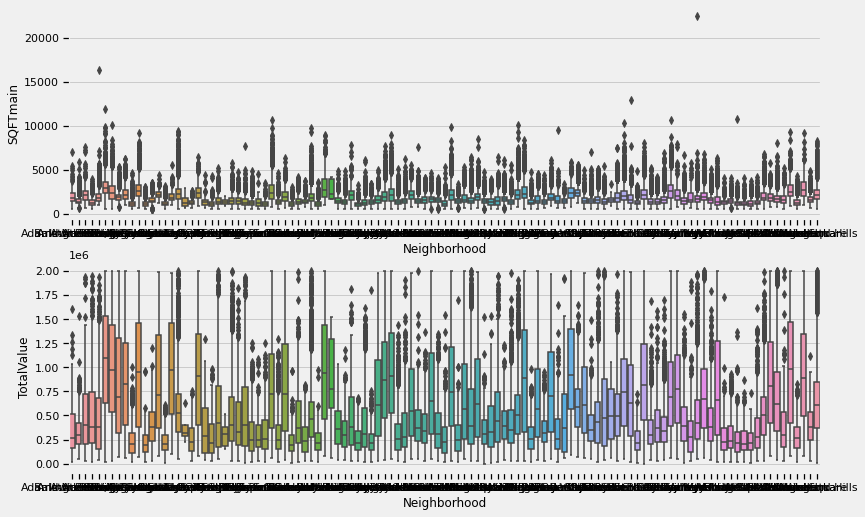

In [18]:
# Find a feature that can help distinguish between richer and "poorer" neighborhoods
fig, axs = plt.subplots(nrows=2, figsize=(12,8))

sns.boxplot(x='Neighborhood', y='SQFTmain', data=train.sort_values('Neighborhood'), ax=axs[0])
sns.boxplot(x='Neighborhood', y='TotalValue', data=train.sort_values('Neighborhood'), ax=axs[1])
plt.show

In [19]:
train[['Neighborhood', 'SQFTmain']].groupby('Neighborhood').median().sort_values(by = 'SQFTmain', ascending = False).iloc[0:5]

,SQFTmain
Neighborhood,
Bel-Air,2871.0
Hancock Park,2723.0
Windsor Square,2701.0
Brentwood,2535.0
Tarzana,2517.0


It may be considered a data leakage to use TotalValue to find rich and poor neighborhoods, since TotalValue is the target. Use SQFTmain as a work around.

In [20]:
def find_rich_neighborhoods(data, n = 2500, metric=np.median):
    """
    Find wealthy neighborhoods based on the median square footage of a residential property.
    n is the threshold median square footage that determines a rich neighborhood.
    """
    
    # Write your code here.
    neighborhoods = (
        data[['Neighborhood', 'SQFTmain']]                  # Filter the columns of interest
        .groupby(data['Neighborhood'])                      # Group by neighborhoods
        .agg(metric)                                        # Apply the specified aggregation function, default is median
    )
    
    neighborhoods = neighborhoods[neighborhoods['SQFTmain'] > n].index.to_list()
    
    return neighborhoods

# Find rich neighborhoodsv
rich_neighborhoods = find_rich_neighborhoods(train)

# Print rich neighborhoods
print('The rich neighborhoods are: {}'.format(rich_neighborhoods))

The rich neighborhoods are: ['Bel-Air', 'Brentwood', 'Hancock Park', 'Tarzana', 'Windsor Square']


In [21]:
def find_poor_neighborhoods(data, n = 1150, metric=np.median):
    """
    Find poor neighborhoods based on the median square footage of a residential property.
    n is the threshold median square footage that determines a poor neighborhood.
    """
    
    # Write your code here.
    neighborhoods = (
        data[['Neighborhood', 'SQFTmain']]                  # Filter the columns of interest
        .groupby(data['Neighborhood'])                      # Group by neighborhoods
        .agg(metric)                                        # Apply the specified aggregation function, default is median
    )
    
    neighborhoods = neighborhoods[neighborhoods['SQFTmain'] < n].index.to_list()
    
    return neighborhoods

# Find poor neighborhoods
poor_neighborhoods = find_poor_neighborhoods(train)

# Print poor neighborhoods
print('The poor neighborhoods are: {}'.format(poor_neighborhoods))

The poor neighborhoods are: ['Boyle Heights', 'Broadway-Manchester', 'Central-Alameda', 'Cypress Park', 'Elysian Valley', 'Florence', 'Green Meadows', 'Harvard Park', 'Lincoln Heights', 'Vermont-Slauson', 'Watts']


In [22]:
def add_in_neighborhoods(data, rich_neighborhoods, poor_neighborhoods):
    """
    Input:
      data (data frame): a data frame containing a 'Neighborhood'
      rich_neighborhoods (list of strings): strings should be the names of neighborhoods
        pre-identified as rich
      poor_neighborhoods (list of strings): strings should be the names of neighborhoods
        pre-identified as poor
    Output:
      data frame identical to the input with the addition of two binary
      in_rich_neighborhood and in_poor_neighborhood columns
    """
    data_copy = data.copy()
    
    # Write your code here.
    data_copy['in_rich_neighborhood'] = (
        data_copy['Neighborhood']           # Filter the series of interest
        .isin(rich_neighborhoods)                # Filter only the rich neighborhoods specified in the 'neighborhoods' list
        .astype('int32')                    # Convert the boolean values to integers
    )
    
    data_copy['in_poor_neighborhood'] = (
        data_copy['Neighborhood']           # Filter the series of interest
        .isin(poor_neighborhoods)                # Filter only the rich neighborhoods specified in the 'neighborhoods' list
        .astype('int32')                    # Convert the boolean values to integers
    )
    
    return data_copy

# Add 'in_rich_neighborhood' feature
training_data = add_in_neighborhoods(training_data, rich_neighborhoods, poor_neighborhoods)

# View DataFrame
training_data.head()

,AIN,SQFTmain,Bedrooms,Bathrooms,LandValue,LandBaseYear,TotalValue,YearBuilt,EffectiveYearBuilt,TaxRateArea,...,cluster,Quartile_Number,PropertyUseCode_0101,PropertyUseCode_0103,PropertyUseCode_0104,YearBuilt_median,EffectiveYearBuilt_median,SQFTmain_median,in_rich_neighborhood,in_poor_neighborhood
0,2341013010,1322.0,3,2,529003.0,2013,654140.0,1947,1950,13,...,4,3,1,0,0,1950.0,1955.0,1638.0,0,0
1,2324028016,1848.0,3,2,294234.0,2015,416367.0,1953,1975,13,...,4,3,0,0,0,1950.0,1955.0,1638.0,0,0
2,2325003019,1078.0,3,1,217813.0,2002,293415.0,1947,1949,13,...,4,2,1,0,0,1950.0,1955.0,1638.0,0,0
3,2325003010,1986.0,5,3,257966.0,2003,489996.0,1947,1970,13,...,4,3,0,0,0,1950.0,1955.0,1638.0,0,0
4,2327006083,2536.0,4,3,243609.0,2001,512261.0,1947,1947,13,...,4,3,1,0,0,1950.0,1955.0,1638.0,0,0


One hot encode the TaxRateArea

In [23]:
taxrate_categories = data['TaxRateArea'].unique()

def ohe_taxratearea(data):
    """
    One-hot-encodes Tax Rate Area.
    New columns are of the form TaxRateArea_AREA
    """
    # List categories
    categories = taxrate_categories

    category_type = pd.CategoricalDtype(categories=categories)
    data['TaxRateArea'] = data['TaxRateArea'].astype(category_type)
    data = pd.get_dummies(data, 
                          prefix='TaxRateArea',
                          columns=['TaxRateArea'], 
                          drop_first=True) # Avoid redundant information
    
    return data

# Encode 'PropertyUseCode'
training_data = ohe_taxratearea(training_data)
training_data

,AIN,SQFTmain,Bedrooms,Bathrooms,LandValue,LandBaseYear,TotalValue,YearBuilt,EffectiveYearBuilt,Cluster,...,TaxRateArea_13245,TaxRateArea_372,TaxRateArea_21,TaxRateArea_482,TaxRateArea_497,TaxRateArea_20,TaxRateArea_308,TaxRateArea_470,TaxRateArea_484,TaxRateArea_13811
0,2341013010,1322.0,3,2,529003.0,2013,654140.0,1947,1950,3154,...,0,0,0,0,0,0,0,0,0,0
1,2324028016,1848.0,3,2,294234.0,2015,416367.0,1953,1975,3136,...,0,0,0,0,0,0,0,0,0,0
2,2325003019,1078.0,3,1,217813.0,2002,293415.0,1947,1949,3136,...,0,0,0,0,0,0,0,0,0,0
3,2325003010,1986.0,5,3,257966.0,2003,489996.0,1947,1970,3136,...,0,0,0,0,0,0,0,0,0,0
4,2327006083,2536.0,4,3,243609.0,2001,512261.0,1947,1947,3136,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292588,5130010044,1288.0,2,1,131887.0,1995,147388.0,1900,1912,23840,...,0,0,0,0,0,0,0,0,0,0
292589,2017002018,1402.0,2,2,139200.0,2001,330708.0,1928,1950,2121,...,0,0,0,0,0,0,0,0,0,0
292590,2017002023,979.0,1,1,156677.0,2003,311057.0,1929,1930,2121,...,0,0,0,0,0,0,0,0,0,0
292591,2017002070,2950.0,4,3,269955.0,2013,630574.0,1990,1990,2121,...,0,0,0,0,0,0,0,0,0,0


In [24]:
def select_columns(data, *columns):
    """Select only columns passed as arguments."""
    return data.loc[:, columns]

In [25]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 292593 entries, 0 to 292592
Columns: 143 entries, AIN to TaxRateArea_13811
dtypes: float64(10), geometry(1), int32(2), int64(10), object(3), uint8(117)
memory usage: 90.7+ MB


In [41]:
def process_data(data):
    """Combine all pipelines to create processed data."""
    # One-hot-encode PropertyUseCode feature
    data = ohe_pusecode(data)
    
    # One-hot-encode TaxRateArea feature
    data = ohe_taxratearea(data)
    
    # Merge median neighborhood metrics
    data = median_neighborhood_merge(data)
    
    # Add in the rich and poor neighborhoods
    data = add_in_neighborhoods(data, rich_neighborhoods, poor_neighborhoods)
    
    # Add in the ratio between square footage of structure to lot
    data = HousetoParcel(data)
    
    # Transform Data, Select Features
    data = select_columns(data, 
                         'SQFTmain',
                         'Bedrooms',
                         'Bathrooms',
                         'LandBaseYear',
                         'TotalValue',
                         'YearBuilt',
                         'EffectiveYearBuilt',
                         'ShapeSTAre',
                         'ShapeSTLen',
                         'crime_count',
                         'PropertyUseCode_0101',
                         'PropertyUseCode_0103',
                         'PropertyUseCode_0104',
                         'YearBuilt_median',
                         'EffectiveYearBuilt_median',
                         'SQFTmain_median',
                         'in_rich_neighborhood',
                         'in_poor_neighborhood',
                         'TaxRateArea_8852',
                         'TaxRateArea_37',
                         'TaxRateArea_13',
                         'TaxRateArea_7',
                         'TaxRateArea_6659',
                         'TaxRateArea_67',
                         'TaxRateArea_292',
                         'TaxRateArea_51',
                         'TaxRateArea_13257',
                         'TaxRateArea_13261',
                         'TaxRateArea_13764',
                         'TaxRateArea_408',
                         'TaxRateArea_13766',
                         'TaxRateArea_5977',
                         'TaxRateArea_5976',
                         'TaxRateArea_13765',
                         'TaxRateArea_13767',
                         'TaxRateArea_5975',
                         'TaxRateArea_1725',
                         'TaxRateArea_464',
                         'TaxRateArea_50',
                         'TaxRateArea_65',
                         'TaxRateArea_2318',
                         'TaxRateArea_8856',
                         'TaxRateArea_8859',
                         'TaxRateArea_8849',
                         'TaxRateArea_8831',
                         'TaxRateArea_42',
                         'TaxRateArea_9938',
                         'TaxRateArea_1723',
                         'TaxRateArea_208',
                         'TaxRateArea_381',
                         'TaxRateArea_8860',
                         'TaxRateArea_660',
                         'TaxRateArea_212',
                         'TaxRateArea_304',
                         'TaxRateArea_6612',
                         'TaxRateArea_307',
                         'TaxRateArea_8842',
                         'TaxRateArea_4591',
                         'TaxRateArea_68',
                         'TaxRateArea_4592',
                         'TaxRateArea_414',
                         'TaxRateArea_210',
                         'TaxRateArea_3170',
                         'TaxRateArea_9951',
                         'TaxRateArea_401',
                         'TaxRateArea_398',
                         'TaxRateArea_2449',
                         'TaxRateArea_12',
                         'TaxRateArea_6660',
                         'TaxRateArea_204',
                         'TaxRateArea_56',
                         'TaxRateArea_8841',
                         'TaxRateArea_501',
                         'TaxRateArea_440',
                         'TaxRateArea_34',
                         'TaxRateArea_312',
                         'TaxRateArea_313',
                         'TaxRateArea_23',
                         'TaxRateArea_48',
                         'TaxRateArea_163',
                         'TaxRateArea_6657',
                         'TaxRateArea_36',
                         'TaxRateArea_29',
                         'TaxRateArea_30',
                         'TaxRateArea_35',
                         'TaxRateArea_12706',
                         'TaxRateArea_8830',
                         'TaxRateArea_6658',
                         'TaxRateArea_4',
                         'TaxRateArea_15117',
                         'TaxRateArea_12703',
                         'TaxRateArea_12704',
                         'TaxRateArea_27',
                         'TaxRateArea_9030',
                         'TaxRateArea_46',
                         'TaxRateArea_47',
                         'TaxRateArea_8827',
                         'TaxRateArea_201',
                         'TaxRateArea_200',
                         'TaxRateArea_324',
                         'TaxRateArea_8832',
                         'TaxRateArea_293',
                         'TaxRateArea_297',
                         'TaxRateArea_460',
                         'TaxRateArea_461',
                         'TaxRateArea_8834',
                         'TaxRateArea_6654',
                         'TaxRateArea_296',
                         'TaxRateArea_465',
                         'TaxRateArea_8835',
                         'TaxRateArea_463',
                         'TaxRateArea_284',
                         'TaxRateArea_509',
                         'TaxRateArea_6650',
                         'TaxRateArea_309',
                         'TaxRateArea_19',
                         'TaxRateArea_14',
                         'TaxRateArea_375',
                         'TaxRateArea_321',
                         'TaxRateArea_399',
                         'TaxRateArea_400',
                         'TaxRateArea_18',
                         'TaxRateArea_13245',
                         'TaxRateArea_372',
                         'TaxRateArea_21',
                         'TaxRateArea_482',
                         'TaxRateArea_497',
                         'TaxRateArea_20',
                         'TaxRateArea_308',
                         'TaxRateArea_470',
                         'TaxRateArea_484',
                         'TaxRateArea_13811'
                         )
    
    # Return predictors and response variables separately
    X = data.drop(['TotalValue'], axis = 1)
    y = data.loc[:, 'TotalValue']
    
    return X, y

    Copy of all features considered for use:
    
    data = select_columns(data, 
                         'SQFTmain',
                         'Bedrooms',
                         'Bathrooms',
                         'LandBaseYear',
                         'TotalValue',
                         'YearBuilt',
                         'EffectiveYearBuilt',
                         'ShapeSTAre',
                         'ShapeSTLen',
                         'crime_count',
                         'PropertyUseCode_0101',
                         'PropertyUseCode_0103',
                         'PropertyUseCode_0104',
                         'YearBuilt_median',
                         'EffectiveYearBuilt_median',
                         'SQFTmain_median',
                         'in_rich_neighborhood',
                         'in_poor_neighborhood',
                         'TaxRateArea_8852',
                         'TaxRateArea_37',
                         'TaxRateArea_13',
                         'TaxRateArea_7',
                         'TaxRateArea_6659',
                         'TaxRateArea_67',
                         'TaxRateArea_292',
                         'TaxRateArea_51',
                         'TaxRateArea_13257',
                         'TaxRateArea_13261',
                         'TaxRateArea_13764',
                         'TaxRateArea_408',
                         'TaxRateArea_13766',
                         'TaxRateArea_5977',
                         'TaxRateArea_5976',
                         'TaxRateArea_13765',
                         'TaxRateArea_13767',
                         'TaxRateArea_5975',
                         'TaxRateArea_1725',
                         'TaxRateArea_464',
                         'TaxRateArea_50',
                         'TaxRateArea_65',
                         'TaxRateArea_2318',
                         'TaxRateArea_8856',
                         'TaxRateArea_8859',
                         'TaxRateArea_8849',
                         'TaxRateArea_8831',
                         'TaxRateArea_42',
                         'TaxRateArea_9938',
                         'TaxRateArea_1723',
                         'TaxRateArea_208',
                         'TaxRateArea_381',
                         'TaxRateArea_8860',
                         'TaxRateArea_660',
                         'TaxRateArea_212',
                         'TaxRateArea_304',
                         'TaxRateArea_6612',
                         'TaxRateArea_307',
                         'TaxRateArea_8842',
                         'TaxRateArea_4591',
                         'TaxRateArea_68',
                         'TaxRateArea_4592',
                         'TaxRateArea_414',
                         'TaxRateArea_210',
                         'TaxRateArea_3170',
                         'TaxRateArea_9951',
                         'TaxRateArea_401',
                         'TaxRateArea_398',
                         'TaxRateArea_2449',
                         'TaxRateArea_12',
                         'TaxRateArea_6660',
                         'TaxRateArea_204',
                         'TaxRateArea_56',
                         'TaxRateArea_8841',
                         'TaxRateArea_501',
                         'TaxRateArea_440',
                         'TaxRateArea_34',
                         'TaxRateArea_312',
                         'TaxRateArea_313',
                         'TaxRateArea_23',
                         'TaxRateArea_48',
                         'TaxRateArea_163',
                         'TaxRateArea_6657',
                         'TaxRateArea_36',
                         'TaxRateArea_29',
                         'TaxRateArea_30',
                         'TaxRateArea_35',
                         'TaxRateArea_12706',
                         'TaxRateArea_8830',
                         'TaxRateArea_6658',
                         'TaxRateArea_4',
                         'TaxRateArea_15117',
                         'TaxRateArea_12703',
                         'TaxRateArea_12704',
                         'TaxRateArea_27',
                         'TaxRateArea_9030',
                         'TaxRateArea_46',
                         'TaxRateArea_47',
                         'TaxRateArea_8827',
                         'TaxRateArea_201',
                         'TaxRateArea_200',
                         'TaxRateArea_324',
                         'TaxRateArea_8832',
                         'TaxRateArea_293',
                         'TaxRateArea_297',
                         'TaxRateArea_460',
                         'TaxRateArea_461',
                         'TaxRateArea_8834',
                         'TaxRateArea_6654',
                         'TaxRateArea_296',
                         'TaxRateArea_465',
                         'TaxRateArea_8835',
                         'TaxRateArea_463',
                         'TaxRateArea_284',
                         'TaxRateArea_509',
                         'TaxRateArea_6650',
                         'TaxRateArea_309',
                         'TaxRateArea_19',
                         'TaxRateArea_14',
                         'TaxRateArea_375',
                         'TaxRateArea_321',
                         'TaxRateArea_399',
                         'TaxRateArea_400',
                         'TaxRateArea_18',
                         'TaxRateArea_13245',
                         'TaxRateArea_372',
                         'TaxRateArea_21',
                         'TaxRateArea_482',
                         'TaxRateArea_497',
                         'TaxRateArea_20',
                         'TaxRateArea_308',
                         'TaxRateArea_470',
                         'TaxRateArea_484',
                         'TaxRateArea_13811',
                         'HousetoParcel'
                         )

In [42]:
X_train, y_train = process_data(train)
    
X_train.head()

,SQFTmain,Bedrooms,Bathrooms,LandBaseYear,YearBuilt,EffectiveYearBuilt,ShapeSTAre,ShapeSTLen,crime_count,PropertyUseCode_0101,...,TaxRateArea_372,TaxRateArea_21,TaxRateArea_482,TaxRateArea_497,TaxRateArea_20,TaxRateArea_308,TaxRateArea_470,TaxRateArea_484,TaxRateArea_13811,HousetoParcel
0,1322.0,3,2,2013,1947,1950,7970.215820,385.672880,5110,1,...,0,0,0,0,0,0,0,0,0,16.586753
1,1848.0,3,2,2015,1953,1975,6556.456055,350.843039,5110,0,...,0,0,0,0,0,0,0,0,0,28.185959
2,1078.0,3,1,2002,1947,1949,8555.039062,367.223888,5110,1,...,0,0,0,0,0,0,0,0,0,12.600761
3,1986.0,5,3,2003,1947,1970,8872.260742,415.723212,5110,0,...,0,0,0,0,0,0,0,0,0,22.384374
4,2536.0,4,3,2001,1947,1947,11313.377930,437.683148,5110,1,...,0,0,0,0,0,0,0,0,0,22.415940


## Create Linear Regression Model

Create a cross-validation function returning the root mse from all splits. Cannot stratify this KFold since the target values are unique float values.

In [43]:
def cross_validate_rmse(model, X, y):
    
    # Setup
    model = clone(model)
    five_fold = KFold(n_splits=5)   # Split the data into 5 parts
    rmse_values = []                # Initialize the list of rmse values, to be populated
    
    # Iterature through cv-folds
    for train_index, val_index in five_fold.split(X):
        
        # Write your code here.
        
        # Fit model
        model.fit(X.iloc[train_index], y.iloc[train_index])   # Take four parts as the training set, iterated through all possibilities
        y_predicted = model.predict(X.iloc[val_index])        # Take one part as the validation set
        
        # Append RMSE scores
        rmse_values.append(mean_squared_error(y.iloc[val_index], y_predicted, squared = False))   # Append to empty list per iteration to populate the rmse values list
        
    return rmse_values

In [44]:
cv_scores = cross_validate_rmse(LinearRegression(), X_train, y_train)

# Print cv scores
print('Cross-validation RMSE scores: {}'.format(cv_scores))
print('Cross-validation RMSE scores mean: ${}'.format(np.mean(cv_scores)))
print('Cross-validation RMSE scores std: ${}'.format(np.std(cv_scores)))

# Find the model percent error
print('Mean home price: ${}'.format(np.mean(data['TotalValue'])))

Cross-validation RMSE scores: [202207.9693012266, 191414.87458712354, 192016.2994490359, 247567.40916302893, 238068.92151923786]
Cross-validation RMSE scores mean: $214255.09480393058
Cross-validation RMSE scores std: $23825.1192737963
Mean home price: $503869.5422030618


In [45]:
X_val, y_val = process_data(val)
cv_scores = cross_validate_rmse(LinearRegression(), X_val, y_val)

# Print cv scores
print('Cross-validation RMSE scores: {}'.format(cv_scores))
print('Cross-validation RMSE scores mean: ${}'.format(np.mean(cv_scores)))
print('Cross-validation RMSE scores std: ${}'.format(np.std(cv_scores)))

Cross-validation RMSE scores: [211777.5622012382, 209687.5570761416, 195901.57814133403, 226059.61944011765, 236367.21403006275]
Cross-validation RMSE scores mean: $215958.70617777883
Cross-validation RMSE scores std: $13983.084799627686


In [46]:
X_test, y_test = process_data(test)
cv_scores = cross_validate_rmse(LinearRegression(), X_test, y_test)

# Print cv scores
print('Cross-validation RMSE scores: {}'.format(cv_scores))
print('Cross-validation RMSE scores mean: ${}'.format(np.mean(cv_scores)))
print('Cross-validation RMSE scores std: ${}'.format(np.std(cv_scores)))

Cross-validation RMSE scores: [159747.35061542725, 198680.9839698905, 234386.19260303167, 241363.14357005255, 246265.84762800095]
Cross-validation RMSE scores mean: $216088.70367728057
Cross-validation RMSE scores std: $32746.39583268758
